# Machine Learning in Python - Project 2

Due Friday, April 9th by 5 pm UK local time.

Group Members: 

Mak Po Wun S2081028 <br>
Sasha Dunstan S1802092 <br>
Nguyen Cong S2133124 <br>
Masaki Kurihara S2121881 <br>

## 0. Setup

In [1]:
# Install required packages
!pip install -q -r requirements.txt

In [2]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

## 1. Introduction



Booking cancellations are disruptive for demand-management decisions for the hotel industry, resulting in hotels implementing strict cacellation policies and overbooking strategies which may not be the best way to circumvent the problems. Our team believes that by building a model that can predict hotel cancellations accurately, we are able to better inform hotels, helping them improve their revenue management, forecasts and policies.

Utilising hotel booking data collected in 2019 collected from the booking systems of two hotels, we aim to identify the features that are important for predicting booking cancellations. There are 29 features in total and a large number of observations. Data cleaning is required since there are many duplicated rows and implausible observations. By comparing the correlation between booking cancellations and the features, we were able to filter out certain features that were insignificant for prediction. Since certain categorical features would result in a large increase in feature numbers upon performing feature engineering, we relabelled these categorical variables in order to avoid the curse of dimensionality and also to reduce computational cost. 

We then fit different types of models to the transformed dataset. Taking into account the imbalanced class distribution of the data, we will not be using accuracy as the metric for model selection. Instead, we seek a recall-precision tradeoff in order to find a balance between false positives and false negatives. This is achieved by looking at the f1 score. In the end, we have chosen a Random Forest Classifier model, which has an f1-score of 67% and accuracy of 83%. 

## 2. Exploratory Data Analysis and Feature Engineering

In [3]:
# Load data
d = pd.read_csv("hotel.csv")
df=d

## Data cleaning


Upon inspection, we noticed several issues with the dataset:
- There are bookinbgs whereby there are no guests (number of adults, children and babies are all 0).
- There are boookings made by chldren and babies.
- The average daily rate (adr) is 0 or negative.
- There are bookings that correspond to 0 nights of stays
- There are duplicated rows.

We remove these instances from the dataset. Also, columns like `company`, `agent`, `children` and `country` consist of NA values. While  a large proportion (68%) of observations is missing under the `company` column, the missingness for the other columns are relatively small. Therefore, we will drop the compamy column and impute missing values for the other columns using mean imputation (children) and mode imputation (agent and country)

In [4]:
df1 = df[(df['adults']==0)&(df['children']==0)&(df['babies']==0)]
df2 = df[(df['adults']==0)&(df['children']>0)&(df['babies']>0)]
df3 = df[df['adr']<= 0]
df4 = df[df['adr']==0]
df5 = df[(df['stays_in_weekend_nights']==0) & (df['stays_in_week_nights']==0)]
df_invalid = pd.concat([df1,df2,df3,df4])
df.drop(df_invalid.index,inplace = True)
#Drop duplicated rows
df = df.drop_duplicates()
#Checking for columns with missing values and calculating the percentages
data = {'Missing value count': df.isnull().sum(), 'Percentage (%)': (df.isnull().sum()/d.shape[0]) * 100}
df_missing = pd.DataFrame(data=data)
print(df_missing[df_missing['Missing value count'] > 0])
#too many missing values for company, so remove entire column
df=df.drop(columns=['company'], axis=1)
#mean imputation for children(round up to nearest integer) 
import math
df['children']=df['children'].fillna(math.ceil(df['children'].mean()))
#mode imputation for country
df['agent'] = df['agent'].fillna(df.agent.mode()[0])
df['country']=df['country'].fillna(df.country.mode()[0])
#Check if there are stil any missing values
#np.sum(df.isnull())

          Missing value count  Percentage (%)
children                    4        0.003407
country                   435        0.370541
agent                   11270        9.599986
company                 80465       68.541518


## Selecting numerical features according to correlation value
The variables are sorted according to their correlation with the target variables `is_canceled`. Using a threshold of magnitude 0.05, we will drop variables (except for `year` and `agent` which we will be treating as categorical variables) whereby the correlation is less than this threshold.

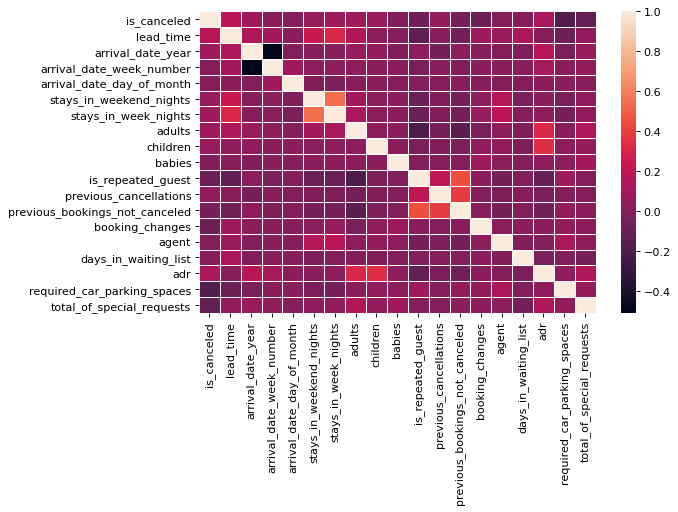

is_canceled                       1.000000
required_car_parking_spaces       0.185792
lead_time                         0.180743
total_of_special_requests         0.120406
adr                               0.119421
booking_changes                   0.091333
arrival_date_year                 0.088155
adults                            0.083236
is_repeated_guest                 0.081735
stays_in_week_nights              0.079957
children                          0.068417
stays_in_weekend_nights           0.057066
previous_cancellations            0.052665
previous_bookings_not_canceled    0.049800
babies                            0.020242
agent                             0.005198
arrival_date_day_of_month         0.005000
arrival_date_week_number          0.002570
days_in_waiting_list              0.002073
Name: is_canceled, dtype: float64


In [5]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, linewidths=.5)
plt.show()
print(corrMatrix["is_canceled"].abs().sort_values(ascending=False))
df=df.drop(columns=['arrival_date_week_number','arrival_date_day_of_month', 'days_in_waiting_list','babies','previous_bookings_not_canceled'], axis=1)

## EDA

The pie chart below represents the percentage of booking that were cancelled VS booking that were not cancelled. There seems to be an uneven class distribution, with the proportion of bookings that were not cancelled dominating the proportion cancelled bookings.

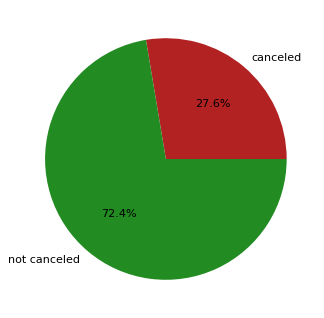

In [6]:
cancel_status_count=[len(df[df.is_canceled==1]),len(df[df.is_canceled==0])]

ax=plt.pie(x=cancel_status_count, labels=['canceled', 'not canceled'],autopct='%1.1f%%',colors=['firebrick', 'forestgreen'])

## Looking at the relationship between the numerical features  and the cancellation status
 `lead_time`, `previous_cancellations`, `adr`, `booking_changes`, `required_car_parking_spaces`,`total_of_special_requests` ,`adults`, `children`
 ### What is the effect of `lead_time` on cancellation?

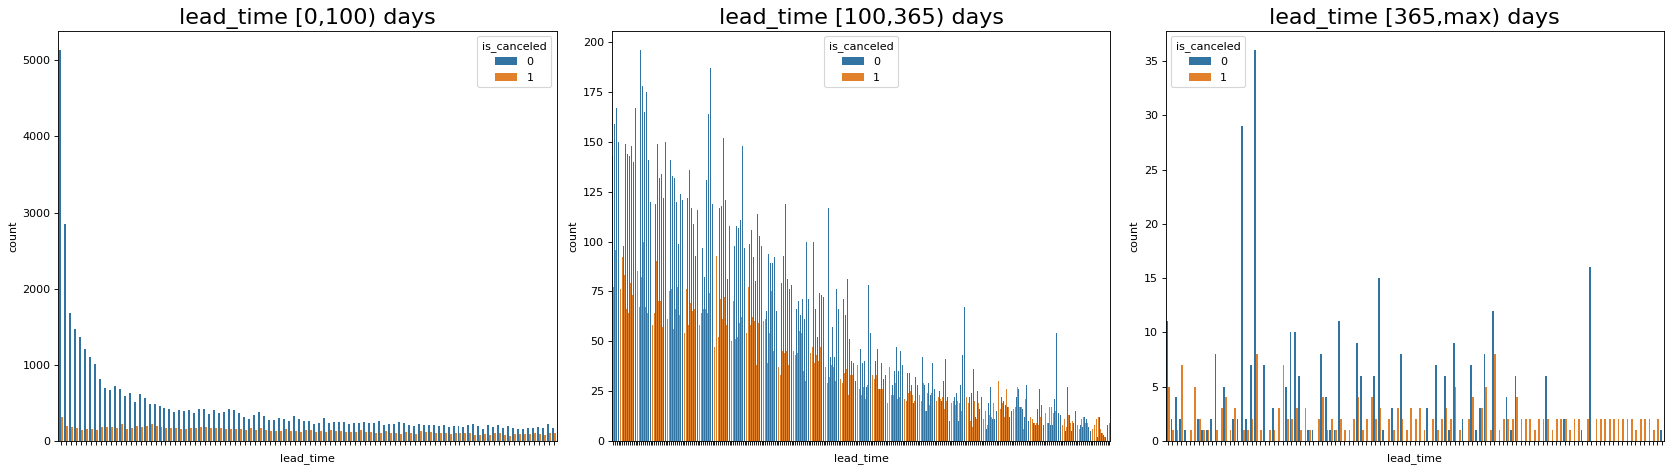

In [7]:
lead_time_1 = df[df["lead_time"] < 100]
lead_time_2 = df[(df["lead_time"] >= 100) & (df["lead_time"] < 365)]
lead_time_3 = df[df["lead_time"] >= 365]
# hist plot for each lead time group
fig, axes = plt.subplots(1,3,figsize=(21,6))
sns.countplot(x=lead_time_1['lead_time'],hue = lead_time_1['is_canceled'], ax=axes[0])
axes[0].set_title("lead_time [0,100) days", size=20)
axes[0].set(xticklabels=[]) 
sns.countplot(x=lead_time_2['lead_time'],hue = lead_time_2['is_canceled'], ax=axes[1])
axes[1].set_title("lead_time [100,365) days", size=20)
axes[1].set(xticklabels=[]) 
sns.countplot(x=lead_time_3['lead_time'],hue = lead_time_3['is_canceled'],ax=axes[2])
axes[2].set_title("lead_time [365,max) days", size=20)
axes[2].set(xticklabels=[]) 
plt.tight_layout()
plt.show()


It appears that most bookings were made within a short time prior to the arrival date. As `lead_time` increases, the proportion of cancelled bookings increases as well.

### How does number of previous cancellations affect cancellation rates?

<AxesSubplot:xlabel='previous_cancellations', ylabel='Percentage of cancellations (%)'>

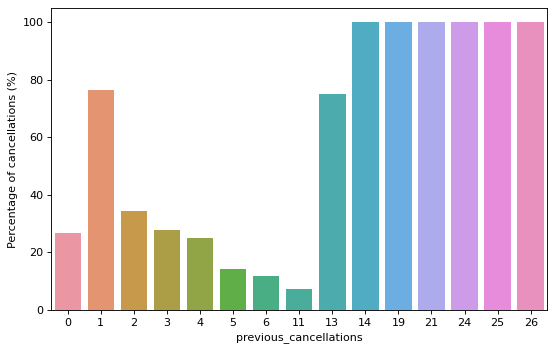

In [8]:

#function for creating data frame with count numbers, canellation percentage
def canceled_percent(col):
     '''
     make a data set of cancellation percentage in terms of a given column 
     '''
     col_canceled=pd.DataFrame(df[df.is_canceled==1][col].value_counts().reindex(df[col].unique(), fill_value=0))
     col_canceled=col_canceled.rename(columns={col: 'canceled_count'})
     col_not_canceled=pd.DataFrame(df[df.is_canceled==0][col].value_counts().reindex(df[col].unique(), fill_value=0))
     col_not_canceled=col_not_canceled.rename(columns={col: 'not_canceled_count'})
     col_total_count=pd.DataFrame(df[col].value_counts())
     col_total_count=col_total_count.rename(columns={col:'total_count'})
     df_col=pd.concat([col_canceled,col_not_canceled,col_total_count],axis=1)
     df_col['Percentage of cancellations (%)']=round(df_col['canceled_count']/df_col['total_count']*100,2)
     df_col=df_col.reset_index().rename(columns={'index':col}).sort_values(by='total_count',ascending=False)
     return df_col

df_prev_cancel_perc = canceled_percent('previous_cancellations')

sns.barplot(x=df_prev_cancel_perc['previous_cancellations'], y=df_prev_cancel_perc['Percentage of cancellations (%)'])

We observe that for customers who have never cancelled a booking, it is unlikely for them to cancel a booking in the future. For those who have previously cancelled once, the rate of future cancellations seems to be high. For number of previous cancellations between  between 2 to 11, the chances of cancelling a booking in the future is quite low. In general, for higher number of previous cancellations, the percentage of cancellations is very high. 

### ADR and cancellations

<AxesSubplot:xlabel='is_canceled', ylabel='adr'>

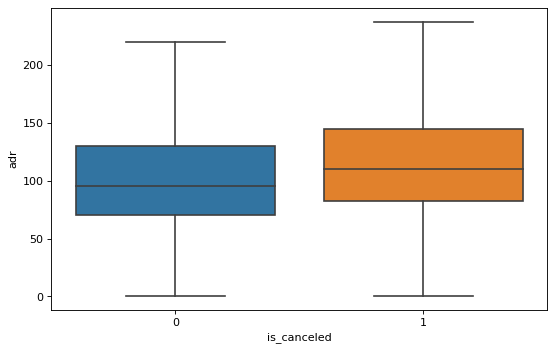

In [9]:
#showfliers=False to remove outliers
sns.boxplot(x='is_canceled',y='adr', data=df,showfliers=False)

Looking at the boxplots, it seems that bookings that were cancelled are associated with a slightly higher ADR in contrast to booking that were not canceled.

### How do car parking spaces and special requests affect cancellation status?

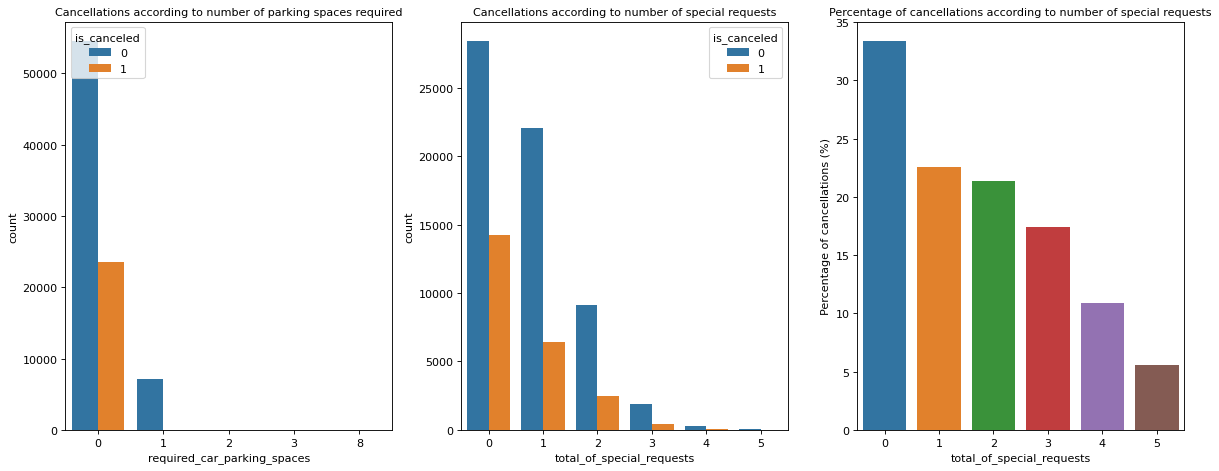

In [10]:
fig, axes = plt.subplots(1,3,figsize=(15,6))
sns.countplot(x=df['required_car_parking_spaces'],hue = df['is_canceled'], ax=axes[0])
axes[0].set_title("Cancellations according to number of parking spaces required", size=10)
sns.countplot(x=df['total_of_special_requests'],hue = df['is_canceled'], ax=axes[1])
axes[1].set_title("Cancellations according to number of special requests", size=10)
df_sr_cancel = canceled_percent('total_of_special_requests')
sns.barplot(x=df_sr_cancel['total_of_special_requests'], y=df_sr_cancel['Percentage of cancellations (%)'],ax=axes[2])
axes[2].set_title('Percentage of cancellations according to number of special requests', size=10)
plt.tight_layout()
plt.show()


It seems that cancelled bookings are only associated with guests that do not require any parking spaces. The percentage of cancellations decreases with the number of special requests. 

### Cancellations according to the number of adults and children 

Text(0.5, 1.0, 'Cancellations according to number of special requests')

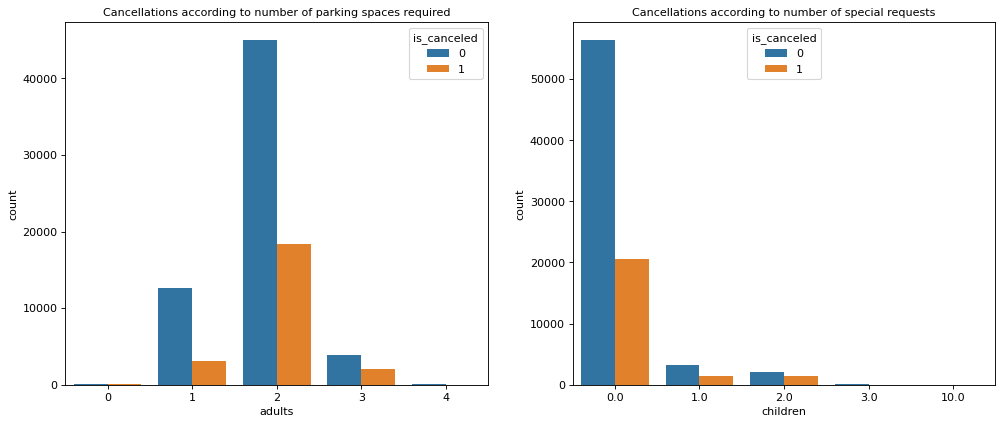

In [11]:
fig, axes = plt.subplots(1,2,figsize=(15,6))
sns.countplot(x=df['adults'],hue = df['is_canceled'], ax=axes[0])
axes[0].set_title("Cancellations according to number of parking spaces required", size=10)
sns.countplot(x=df['children'],hue = df['is_canceled'], ax=axes[1])
axes[1].set_title("Cancellations according to number of special requests", size=10)

## Looking at the relationship between categorical features and cancellations
`hotel`, `arrival_date_months`, `country`, `agent`, `meals`

Percentage of cancellations (Resort Hotel): 0.23560966789223073
Percentage of cancellations (City Hotel): 0.302303281360873


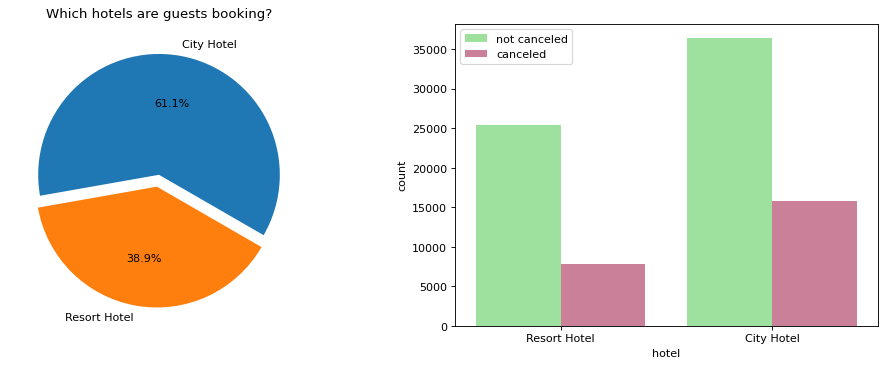

In [12]:
hotel=pd.DataFrame(df.hotel.value_counts())
fig, axes = plt.subplots(1,2,figsize=(15,5))

axes[0].pie(hotel['hotel'], labels=['City Hotel','Resort Hotel'], explode=(0,0.1), autopct='%1.1f%%',startangle=-30)
axes[0].title.set_text('Which hotels are guests booking?')
sns.countplot(x=df["hotel"],hue=df["is_canceled"],palette={0:"lightgreen",1:"palevioletred"},saturation=0.7, ax=axes[1])
plt.legend(["not canceled", "canceled"])
print('Percentage of cancellations (Resort Hotel):',len(df[(df['hotel']=='Resort Hotel') & (df['is_canceled']==1)])/len(df[df['hotel']=='Resort Hotel']))
print('Percentage of cancellations (City Hotel):',len(df[(df['hotel']=='City Hotel') & (df['is_canceled']==1)])/len(df[df['hotel']=='City Hotel']))

The pie bar chart above shows that the number of bookings of city hotel is much higher than that of resort hotel. Even so, the rate of cancellations for both hotels are comparable.
### Booking cancellations according to months and years

We then drop the column of 'arrival_date_year' as some months are not recorded for years 2015,2017 as shown in the bar charts. Therefore, we will not consider using year as a predictor in order not to affect the accuracy.

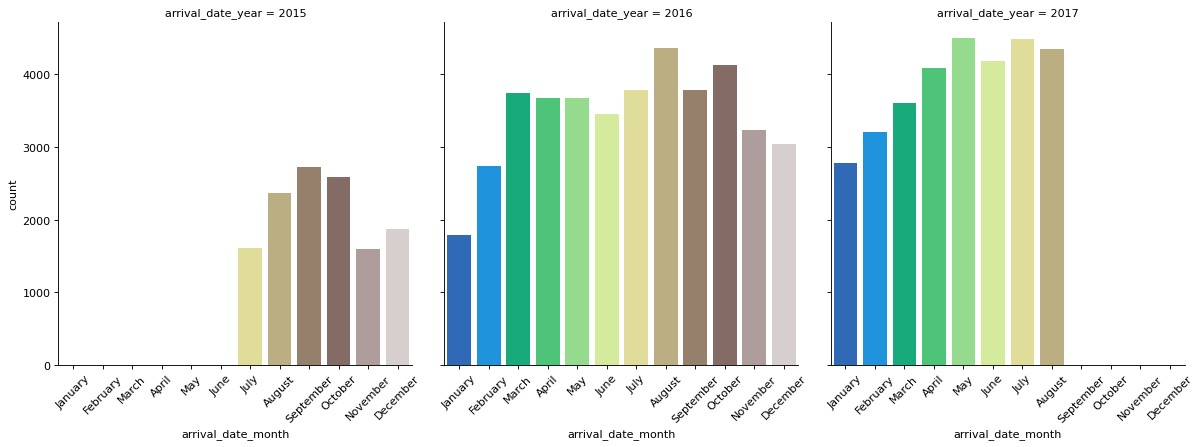

In [13]:
Month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
p1=sns.catplot(x="arrival_date_month", order = Month, col='arrival_date_year',data=df, kind="count", palette="terrain")
p1.set_xticklabels(rotation=45)

#drop arrival_date_year
df=df.drop(columns=['arrival_date_year'], axis=1)

Since observations for years 2015 and 2016 were recorded for only some of the months. We will not use `arrival_date_year` as a predictor. 

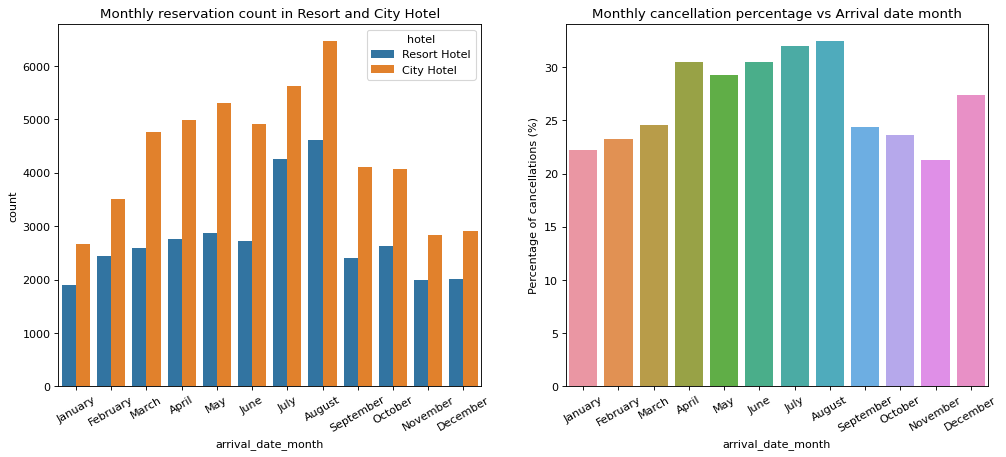

In [14]:
f, ax = plt.subplots(1,2,figsize=(15,6) )
sns.countplot(x = "arrival_date_month", hue = 'hotel',order=Month,data = df,ax=ax[0]).set_title("Monthly reservation count in Resort and City Hotel")
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=30)
df_month=canceled_percent('arrival_date_month')
sns.barplot(x=df_month.arrival_date_month, y=df_month['Percentage of cancellations (%)'], order=Month, ax=ax[1]).set_title("Monthly cancellation percentage vs Arrival date month")
ax[1].set_xticklabels(ax[0].get_xticklabels(),rotation=30)
None

Based on the two bar charts, the number of bookings for both resort hotel and city hotel are the higest during summer months June, July and August. Similarly, the percentage of cancellation is also highest during the summer.
### Booking cancellations according to countries

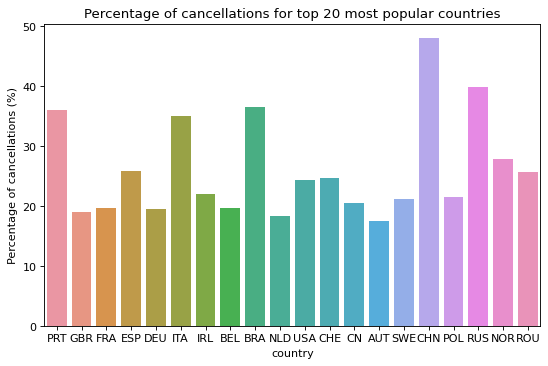

In [15]:
df_country=canceled_percent('country')
import plotly.express as px
guest_map = px.choropleth(df_country,
                    locations=df_country.country,
                    color=df_country['total_count'], 
                    hover_name=df_country.country, 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Home country of guests")
guest_map.show()
c1=sns.barplot(x=df_country['country'][0:20],y=df_country['Percentage of cancellations (%)'][0:20]).set_title("Percentage of cancellations for top 20 most popular countries")

Most of the bookings were made by guests from western Europe, with Portugal dominating the other countries. This makes sense since the two hotels whereby data is collected from are located in Portugal, based on the source of the dataset. The bar chart above shows the percentage of cancellations for the top 20 countries where guests mainly come from.

Since there are altogether 177 countries, and more than 100 of the countries corresponde to less than 0.01% of the dataset, we will group the countries into four categories based on their frequencies in the dataset, namely `High`: More than 10000 observations, `Medium high`: between 5000 and 10000 observations,`Medium low`: between 1000 and 5000 observations, and `Low`: Less than 1


We now relabel the country variables with 'high', 'medium high', 'medium low' and 'low' based on the percentages of canceled bookings.

In [16]:
def regroup_cat(data,percent_data,col):
    '''
     a Function to relabel categorical variables as 'high', 'medium high', 'medium low', and 'low' based on frequency of the value.
    '''
    high=list(percent_data[col][(percent_data['total_count']>10000) & (percent_data['total_count']<=len(df))])
    mid_high=list(percent_data[col][(percent_data['total_count']>5000) & (percent_data['total_count']<=10000)])
    mid_low=list(percent_data[col][(percent_data['total_count']>1000) & (percent_data['total_count']<=5000)])
    low=list(percent_data[col][(percent_data['total_count']>=0) & (percent_data['total_count']<=1000)])
    data[col]=data[col].replace(high, 'High')
    data[col]=data[col].replace(mid_high, 'Medium high')
    data[col]=data[col].replace(mid_low, 'Medium Low')
    data[col]=data[col].replace(low, 'Low')
    return data
regroup_cat(df,df_country,'country').country.value_counts()

High           36639
Medium high    21310
Medium Low     16499
Low            10877
Name: country, dtype: int64

Similarly, the number of unique agent IDs is large, and most of the agents correspond to les than 0.01% of the total observations. Therefore, we apply the same relabelling to the feature 'agent', grouping agent ID into categories based on their freqeuncies. 

In [17]:
df_agent=canceled_percent('agent')
regroup_cat(df, df_agent,'agent').agent.value_counts()

High          52709
Low           16593
Medium Low    16023
Name: agent, dtype: int64

### Cancellations according to `deposit_type`

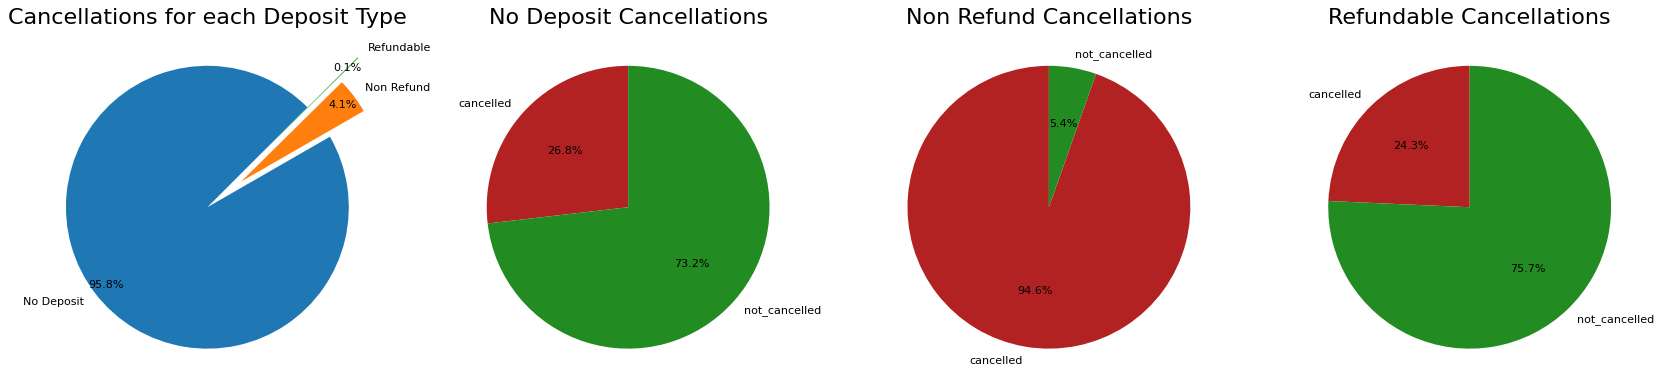

In [18]:
# pie plot of cancellations according to deposit type

no_deposit_0 = len(df[(df['deposit_type']=='No Deposit') & (df['is_canceled']==0)])
no_deposit_1 = len(df[(df['deposit_type']=='No Deposit') & (df['is_canceled']==1)])
non_refund_0 = len(df[(df['deposit_type']=='Non Refund') & (df['is_canceled']==0)])
non_refund_1 = len(df[(df['deposit_type']=='Non Refund') & (df['is_canceled']==1)])
refundable_0 = len(df[(df['deposit_type']=='Refundable') & (df['is_canceled']==0)])
refundable_1 = len(df[(df['deposit_type']=='Refundable') & (df['is_canceled']==1)])
labels1 = ['No Deposit', 'Non Refund', 'Refundable']
labels2 = ["cancelled", "not_cancelled"]
fig, dx = plt.subplots(1,4, figsize=(21,6))
dx[0].pie(np.array([no_deposit_1,non_refund_1,refundable_1]), labels=labels1,autopct='%1.1f%%', startangle=45,pctdistance=0.9,explode=(0,0.3,0.5))
dx[0].set_title("Cancellations for each Deposit Type", size=20)

dx[1].pie(np.array([no_deposit_1, no_deposit_0]), labels=labels2, autopct='%1.1f%%', startangle=90,
          colors=['firebrick', 'forestgreen'])
dx[1].set_title("No Deposit Cancellations", size=20)
dx[2].pie(np.array([non_refund_1, non_refund_0]), labels=labels2, autopct='%1.1f%%', startangle=90,
          colors=['firebrick', 'forestgreen'])
dx[2].set_title("Non Refund Cancellations", size=20)
dx[3].pie(np.array([refundable_1, refundable_0]), labels=labels2, autopct='%1.1f%%', startangle=90,
          colors=['firebrick', 'forestgreen'])
dx[3].set_title("Refundable Cancellations", size=20)
plt.tight_layout()
plt.show()


From the pie charts above, most of the canceled bookings did not require deposit from the customers. By investigating each deposit types, we notice that most of the non refund bookings are cancelled, which seems counterintuitive since we would expect a non refund policy to discourage booking cancellations. 
### Room types and booking cancellations


<AxesSubplot:xlabel='room_type_changed', ylabel='count'>

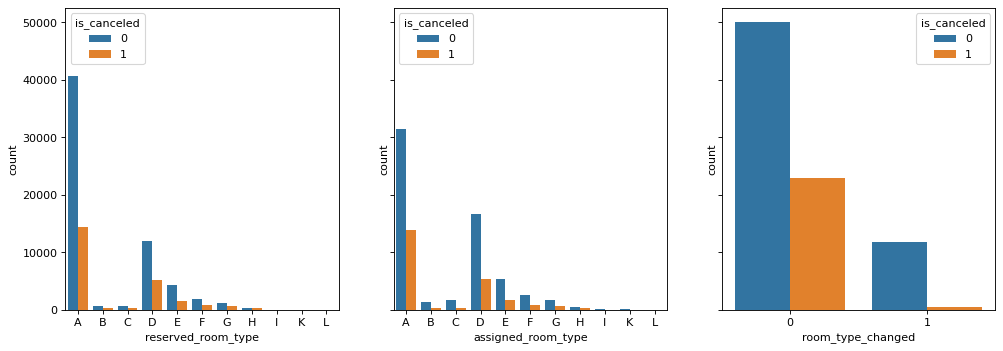

In [19]:
#pretty similar
room_order=['A', 'B', 'C','D', 'E', 'F', 'G', 'H', 'I','K','L']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.countplot(ax=axes[0],x=df['reserved_room_type'],hue=df['is_canceled'], order=room_order)
sns.countplot(ax=axes[1],x=df['assigned_room_type'],hue=df['is_canceled'],order=room_order )


#define a new variable that indicates whether the room reserved is different from the room assigned
df['room_type_changed']=(df['reserved_room_type'] != df['assigned_room_type']).astype(int)
df.drop(columns=['assigned_room_type'],inplace=True)

sns.countplot(x=df['room_type_changed'],hue=df['is_canceled'],ax=axes[2])


The charts for reserved room type and assigned room type seem quite similar, meaning that most of the guests were assigned the rooms they reserved. We can drop the `assigned_room_type` variable, and create a new variable `room_type_change` indicating whether the assigned room type is different from the reserved room type. Based on the bar chart above, it seem that a higher proportion of cancellations is associated with a no change in reserved and assigned room type. 

Text(0.5, 1.0, 'Cancellation count vs type of meal booked')

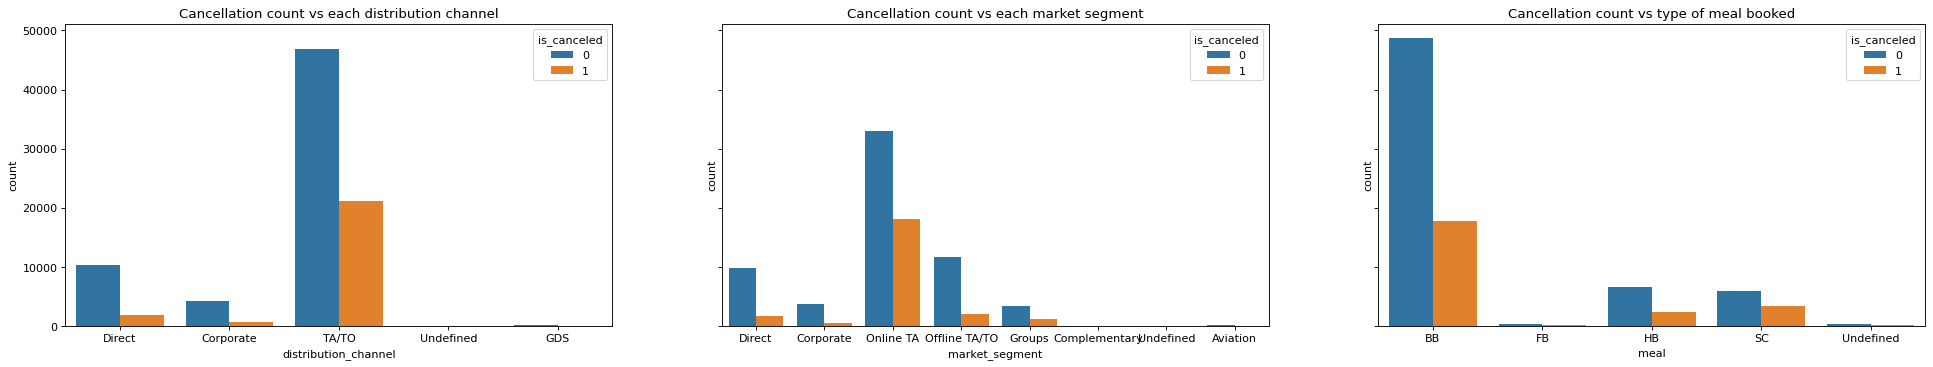

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(30, 5), sharey=True)
sns.countplot(ax=axes[0],x=df['distribution_channel'],hue=df['is_canceled']).set_title("Cancellation count vs each distribution channel")
sns.countplot(ax=axes[1],x=df['market_segment'],hue=df['is_canceled'] ).set_title("Cancellation count vs each market segment")
sns.countplot(ax=axes[2], x=df['meal'],hue=df['is_canceled']).set_title("Cancellation count vs type of meal booked")



Based on the distribution channel, most of the canceled bookings are distrbuted from travel agents or tour operators. Based on the market segment, most of the canceled bookings are designed by online travel agents.

### Feature engineering
We now perform feature engineering for the categorical variables, using one-hot encoding for most of the variables and ordinal encoding for the `country` and `agent` variables, assigning label `0` to the most popular country/agent, `1` to the second most popular and so on.

In [21]:
cat_feat=['hotel','arrival_date_month','meal','reserved_room_type','market_segment','distribution_channel','deposit_type','customer_type']
df=pd.get_dummies(df, columns=cat_feat)
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
df['country']=le.fit_transform(df['country'])
df['agent']=le.fit_transform(df['agent'])

## 3. Model Fitting and Tuning

In [22]:
def roc_plot(y_true, y_pred):
    """ Draw an ROC curve and report AUC
    """
    roc = pd.DataFrame(
        data = np.c_[sklearn.metrics.roc_curve(y_true, y_pred)],
        columns = ('fpr', 'tpr', 'threshold')
    )
    
    sns.lineplot(x='fpr', y='tpr', data=roc, ci=None)

    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.title("ROC curve (auc = %.4f)" % sklearn.metrics.roc_auc_score(y_true, y_pred))
             
    plt.show()

from sklearn.metrics import classification_report, confusion_matrix
#Function returns confusion matrix and classification report for the model
def assess_model(actual, pred):
    print("Confusion Matrix:\n", confusion_matrix(actual, pred), "\n")
    print("Classification Report:\n", classification_report(actual, pred))

In this section, we will be fitting and tuning our model. To decide which metric we will be using for selecting and tuning our model, we will first look at what  True Negatives(TN), True Positives(TP), False Negatives( FN) and False Positives(FP) mean within the context of the dataset.

- TN: Bookings that were not cancelled are predicted to not be cancelled
- TP: Bookings that were cancelled are predicted to be cancelled
- FN: Booking that were actually cancelled but predicted to not be cancelled. 
- FP: Bookings that were actually not cancelled but predicted to be cancelled.

FP would result in customers not having any accommodation and being turned away by the hotel, and this would have an adverse effect on the hotel's reputation. Additionally, the hotel might have to compensate these customers. On the other hand, FN would result in the hotel incurring a loss in terms of resources and costs as the rooms, and services like special requests, meals etc. were prepared beforehand. At the same time, since it was incorrectly predicted that bookings will not be cancelled, a hotel which is fully booked might turn away potential customers who actually require rooms. In short, there negative impacts resulting from both FP and FN, and we should choose a metric that takes these two errors into account, and it is the F1 metric. 

As the data is quite imbalanced(i.e. uneven class distribution between cancelled bookings (28%) and bookings that were not cancelled (72%)), the accuracy can be  disproportionately skewed by a large number of True Negatives, giving us a false impression that the model is performing well even if the precision or recall are low. Since the F1 score is the weighted average of precision and recall, it takes both FP and FN into account to strike a balance between precision and recall.

We first split the data to testing,training and validation sets. The training and validation sets are used particularly for model selection - we have tried fitting models like logistic regression, decision tree, naive bayes (GaussianNB, BernoulliNB), random forest (using default parameter values). As a result, the random forest model is selected. Not only does the random forest model yield the highest F1 score, it performs better in terms of the accuracy as well. Compared to a decision tree, it is also less likely to overfit. 

In [23]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['is_canceled'])
y = df.is_canceled
X_train, X_test, y_train, y_test = train_test_split(X ,y,test_size=0.10, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X ,y,test_size=0.10, random_state=1234) # For model selection

In [24]:
#baseline model 
from sklearn.linear_model import LogisticRegression
m_baseline = LogisticRegression(solver='lbfgs', max_iter=2000).fit(X_train, y_train)
assess_model(y_val, m_baseline.predict(X_val))

Confusion Matrix:
 [[5664  523]
 [1264 1082]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.86      6187
           1       0.67      0.46      0.55      2346

    accuracy                           0.79      8533
   macro avg       0.75      0.69      0.71      8533
weighted avg       0.78      0.79      0.78      8533



From the confusion matrix, the model performs quite well in prediciting True Negatives but it performs badly in predicting True Positives. The number of mispredicted canceled bookings is even more than the number of correctly predicted canceled bookings. Also, from the classification report, the f1-score(0.56) of the canceled bookings is low even though we have the accuracy of 0.79. By plotting the ROC curve and computing the AUC value, it is obvious that the performance of the model at distinguishing between canceled bookings and not canceled bookings is not very good as we just got AUC value of 0.6869 and the ROC curve is quite far away from the top left corner.

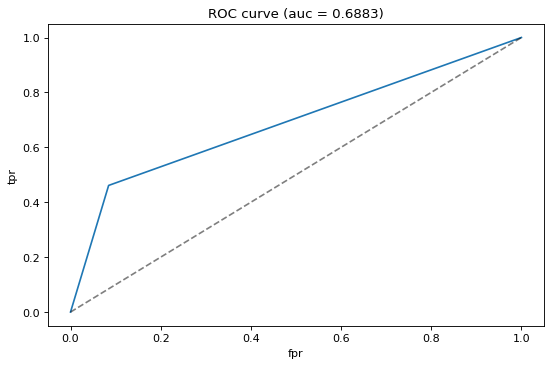

In [25]:
roc_plot(y_test, m_baseline.predict(X_test))

In order to find a better model, we are going to try to fit the model of Random Forest Classifier. We have chosen Gini Impurity as the method of deciding the optimal split of the tree because it is computationally more efficient to compute than Entropy Impurity.

In [26]:
from sklearn.ensemble import RandomForestClassifier
m_rf =RandomForestClassifier(criterion="gini")
m_rf_fit=m_rf.fit(X_train,y_train)
assess_model(y_val, m_rf_fit.predict(X_val))

Confusion Matrix:
 [[5661  526]
 [ 916 1430]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89      6187
           1       0.73      0.61      0.66      2346

    accuracy                           0.83      8533
   macro avg       0.80      0.76      0.78      8533
weighted avg       0.83      0.83      0.83      8533



Based on the confusion matrix, the performance is better in terms of prediciting True Negatives. Although it still performs badly in predicting True Positives, it performs better than the logistic regression model. The number of mispredicted canceled bookings is now much less than the number of correctly predicted canceled bookings. Also, from the classification report, the f1-score(0.66) of the canceled bookings is increased and we have a higher accuracy of 0.83. Comparing with the logistic regression model, the performance of the Random Forest Classifier at distinguishing between canceled bookings and not canceled bookings is improved as we just got a much higher AUC value and the ROC curve is much closer to the top left corner.

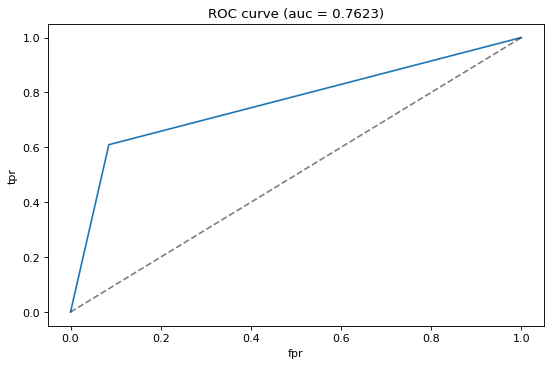

In [27]:
roc_plot(y_val, m_rf_fit.predict(X_val))

We now tune the Random Forest Classifier. We aim to improve model by finding the optimal values of maximum depth, minimum samples and the size of the random subsets of features in splitting. We are going to use RandomizedSearchCV which selects the combinations randomly to search for the optimal values because the run time for RandomizedSearchCV is lower and this is computationally more efficient when compared to GridSearchCV.

In [28]:
#Stratifying each fold is better for handling class imbalance
from sklearn.model_selection import StratifiedKFold
s_kfold = sklearn.model_selection.StratifiedKFold(3, shuffle=True, random_state=121)

In [29]:
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

parameters={'n_estimators' : [100,250,500,750],'max_features': ['sqrt','log2', None], 'max_depth':[5,10,15,20,25]}
ran_search=RandomizedSearchCV(m_rf,parameters,n_iter=10, cv=s_kfold,scoring="f1",n_jobs = -1).fit(X_train, y_train)
print("The best classifier is: ", ran_search.best_params_)

The best classifier is:  {'n_estimators': 250, 'max_features': 'sqrt', 'max_depth': 25}


We then apply the optimal parameters found above to fit the model, and evaluate using the test set.

In [30]:
print("Best cross-validation score: {:.4f}".format(ran_search.best_score_))
m_tuned = RandomForestClassifier(criterion="gini", n_estimators = 500, max_features= None, max_depth = 20).fit(X_train, y_train)
print(assess_model(y_test,m_tuned.predict(X_test)))

Best cross-validation score: 0.6577
Confusion Matrix:
 [[5672  515]
 [ 900 1446]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      6187
           1       0.74      0.62      0.67      2346

    accuracy                           0.83      8533
   macro avg       0.80      0.77      0.78      8533
weighted avg       0.83      0.83      0.83      8533

None


The results are very close to the results for the untuned model. The accuracy is the same as the untuned model. Although the model performs slightly worse in predicting the True Negatives, it improves slightly in predicting the True Positives, resulting in a slight increase in the f1-score(0.68).

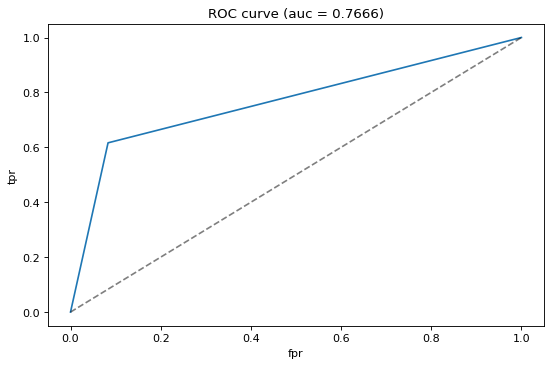

In [31]:
roc_plot(y_test, m_tuned.predict(X_test))

## 4. Discussion & Conclusions

We have chosen the Random Forest Classifier model. It has an accuracy of 83%, meaning that it can correctly predict booking cancellations 83% of the time. With a precision of 74%, our model is able to correctly identify 74% of cancelled bookings that are actually cancelled bookings. With a recall score of 62%, this means that out of all the actual cancelled bookings, our model is able to correctly predict 62% of those cancelled bookings. 

<AxesSubplot:xlabel='importance', ylabel='feature'>

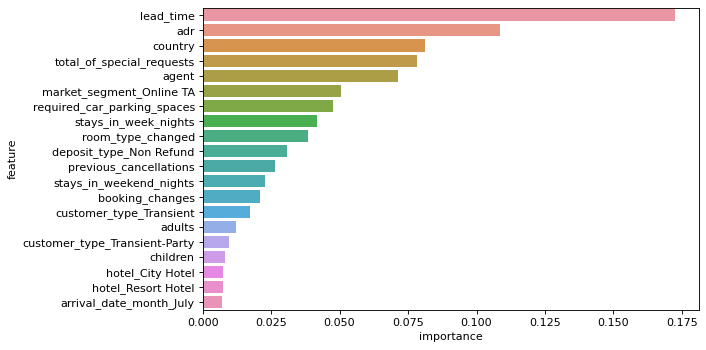

In [32]:
importance = m_tuned.feature_importances_
importance_dict = dict(zip(X_train.columns, importance))
importance_df = pd.DataFrame(importance_dict.items(), columns=['feature', 'importance'])
importance_df_sort = importance_df.sort_values(by=['importance'], ascending=False)
sns.barplot(x=importance_df_sort.importance[:20],y=importance_df_sort.feature[:20], orient="h")

We can look at what features are important for predicting booking cancellations. The bar chart below represents the top 20 most important features and their 'importance values'. `lead_time` is the most important feature. Based on EDA, we have seen that longer increase the chance of cancellations. The second most important feature is the ADR (EDA shows that hgher ADR leads to higher probability of cancellation), followed by guest's country of origin, the number of special requests made by guests and then agents.

In our Random Forest model, it is difficult to interpret how each feature affects booking cancellations; however, we can use 'lime’ module to produce charts that can help better understand how features affect booking cancellations probabilities. In the figure below, we see how certain features of a particular instance from the dataset influence the probability of cancellation. For this paritcular instance, it seems that the higher probability of the booking being cancelled is driven by `required_car_parking_spaces`=0, `room_type_changed`=0, `country`=0(i.e. country from the category 'High' or most popular country of origin). At the same time, `previous_cancellations`=0 and `deposit_type_Non Refund`=0 (i.e. the deposit type is not 'Non Refund') contribute to the probability of non-cancellation, which align with the results obtain from EDA.


In [33]:
import lime
import lime.lime_tabular
predict_fn_rf = lambda x: m_tuned.predict_proba(x).astype(float)
X = X_train.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = X_train.columns,class_names=['Not Cancelled','Cancelled'],kernel_width=5)
choosen_instance = X_test.loc[[53076]].values[0]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf,num_features=15)
exp.show_in_notebook()

This is only an example for one such instance. However, we have looked at multiple instances, and we can conclude that in general, longer lead time, higher ADR, countries and agents that are considered to be popular are associated with higher probability of cancellations. Moreover, guests who do not require any special requests and parking spaces are also prone to cancel their bookings. When there is no change in the reserved and the assigned room, the booking is more likely to be cancelled. This may be due to the fact that room changes were probably upgrades for guests. Also, for deposit type that are not 'non-redunfable', the booking is less likely to be cancelled. This is somewhat counterintuitive since we would expect non-refundable bookings to get cancelled less. 

In conclusion, the Random Forest Classifier model with the tuned parameters (using RandomizedSearchCV) is chosen to be the best model because it has the highest accuracy score, AUC value and f1-score for both canceled and not canceled bookings. This is aligns with our expectations due to the fact that Random Forest Classifier reduces overfitting in decision trees. 

# Limitations
In comparison with decision tree classifier, the model of random forest classifier is hard to interpret as trees are combined in random forests and they tend to be deeper than decision trees. Moreover, the algorithm were slow and lots of time were being spent on running the training model and predictions (due to large number of trees). Another limitation is that the lists of parameters used for searching the optimal model by GridSearchCV and RandomizedSearch CV are limited and it is much more computationally demanding if we add any extra choices of parameters to the lists.

Additionally, there are some missing values in some features of the data such as the months in some years and we cannot make any predictions based on those features. Also, there are many bookings by customers who did not require agents and this may affect model accuracy if we want to predict the cancellation based on the agents. 


## 5. Convert Document

In [34]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf proj2.ipynb

[NbConvertApp] Converting notebook proj2.ipynb to pdf
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Support files will be in proj2_files/
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making directory ./proj2_files
[NbConvertApp] Making di

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0b1a446b-927b-4b44-9a04-bf3d518ef114' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>